# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
train.keys(), test.keys() 

(dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']),
 dict_keys(['__header__', '__version__', '__globals__', 'X', 'y']))

In [4]:
x_train, y_train = train['X'], train['y']
x_test, y_test = test['X'], test['y']

In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

Note: the num of training and etsting samples are at the 3 index, we need to move it.

In [6]:
import numpy as np
x_train = np.moveaxis(x_train, -1, 0)
x_test = np.moveaxis(x_test, -1 , 0)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [7]:
# Plot the first 10 SVHN images
import matplotlib.pyplot as plt

rand_ten_images = np.random.choice(x_train.shape[0], 10)

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
# import pdb; pdb.set_trace()
for i, idx in enumerate(rand_ten_images):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])
plt.show()

<Figure size 1000x100 with 10 Axes>

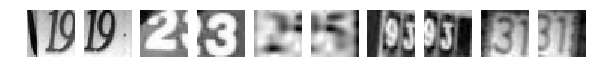

In [8]:
# converting to grayscale
x_train_grayscale = np.mean(x_train, 3)
x_test_grayscale = np.mean(x_test,3)

rand_ten_grayscale_images = np.random.choice(x_train_grayscale.shape[0], 10)

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
# import pdb; pdb.set_trace()
for i, idx in enumerate(rand_ten_grayscale_images):
    ax[i].set_axis_off()
    ax[i].imshow(x_train_grayscale[i], cmap='gray')
plt.show()

In [9]:
x_train_grayscale.shape, len(rand_ten_grayscale_images)

((73257, 32, 32), 10)

In [10]:
# we will need to one_hot_encode our labels, else when fitting with SCCE loss function, our lables will be out of range.
# basically, converting the analog labels to categories
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder().fit(y_train)
y_train = enc.transform(y_train).toarray()
y_test = enc.transform(y_test).toarray()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def get_new_mlp_model(train_data):
    model = Sequential([
        Flatten(input_shape=train_data[0].shape),
        Dense(512, activation='relu'), # key was to have significant perceptrons here, 256 and below did not perform well.
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['acc'])
    return model

In [12]:
# Create an instance of the model and show model summary
model = get_new_mlp_model(x_train)
model.summary()

y_train.max(), y_train.min(), y_test.max(), y_test.min()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1573376   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                6

(1.0, 0.0, 1.0, 0.0)

In [13]:
def get_checkpoint_best_only():
    return ModelCheckpoint(filepath='checkpoints_best_only/checkpoint', 
                            freuency='epoch', 
                            monitor='val_loss', 
                            save_weights_only=True, 
                            save_best_only=True, 
                            verbose=1)

def get_early_stopping():
    return EarlyStopping(monitor='loss', patience=3)

checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

callbacks = [checkpoint_best_only, early_stopping]

In [22]:
# Train model using the callbacks with early stopping and best loss

history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks)

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73248/73257 [============================>.] - ETA: 0s - loss: 5.0882 - acc: 0.2287
Epoch 00001: val_loss improved from inf to 1.83187, saving model to checkpoints_best_only/checkpoint
73257/73257 [==============================] - 160s 2ms/sample - loss: 5.0878 - acc: 0.2287 - val_loss: 1.8319 - val_acc: 0.3869
Epoch 2/30
73248/73257 [============================>.] - ETA: 0s - loss: 1.5437 - acc: 0.4900
Epoch 00002: val_loss improved from 1.83187 to 1.54222, saving model to checkpoints_best_only/checkpoint
73257/73257 [==============================] - 168s 2ms/sample - loss: 1.5437 - acc: 0.4900 - val_loss: 1.5422 - val_acc: 0.5311
Epoch 3/30
73248/73257 [============================>.] - ETA: 0s - loss: 1.3450 - acc: 0.5687
Epoch 00003: val_loss improved from 1.54222 to 1.37294, saving model to checkpoints_best_only/checkpoint
73257/73257 [==============================] - 171s 2ms/sample - loss: 1.3451 - acc: 0.5687 - va

In [43]:
! ls -lh

total 104K
-rwxrwxrwx 1 nobody nogroup  89K Mar 15 23:15 'Capstone Project.ipynb'
drwxr-xr-x 2 jovyan users   6.0K Mar 15 20:46  checkpoints_best_only
drwxr-xr-x 2 jovyan users   6.0K Mar 15 22:40  checkpoints_best_only_cnn
drwxrwxrwx 2 nobody nogroup 6.0K Feb  2 00:54  data


In [16]:
# Plot training and testing curves
import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['val_loss']) # plot loss vs epochs

NameError: name 'history' is not defined

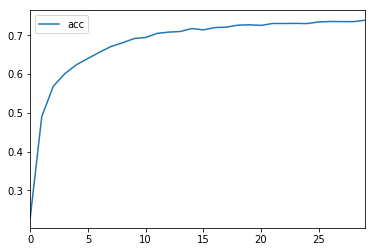

In [25]:
df.plot(y=['acc']) # plot acc vs epochs

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [14]:
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPool2D, Dense

def get_new_cnn_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        BatchNormalization(),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        tf.keras.layers.Dropout(0.3),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
model_cnn = get_new_cnn_model()
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 8)           32        
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dropout (Dropout)            (None, 32)               

In [16]:
def get_checkpoint_best_only():
    return ModelCheckpoint(filepath='checkpoints_best_only_cnn/checkpoint', 
                            freuency='epoch', 
                            monitor='val_loss', 
                            save_weights_only=True, 
                            save_best_only=True, 
                            verbose=1)

def get_early_stopping():
    return EarlyStopping(monitor='loss', patience=3)

checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

callbacks = [checkpoint_best_only, early_stopping]

In [ ]:
# Train model using the callbacks with early stopping and best loss

history_cnn = model_cnn.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test, y_test), 
                    callbacks=callbacks)

Train on 73257 samples, validate on 26032 samples
Epoch 1/30
73248/73257 [============================>.] - ETA: 0s - loss: 1.2362 - accuracy: 0.5904
Epoch 00001: val_loss improved from inf to 0.79050, saving model to checkpoints_best_only_cnn/checkpoint
73257/73257 [==============================] - 421s 6ms/sample - loss: 1.2361 - accuracy: 0.5905 - val_loss: 0.7905 - val_accuracy: 0.7664
Epoch 2/30
73248/73257 [============================>.] - ETA: 0s - loss: 0.7585 - accuracy: 0.7605
Epoch 00002: val_loss improved from 0.79050 to 0.72626, saving model to checkpoints_best_only_cnn/checkpoint
73257/73257 [==============================] - 411s 6ms/sample - loss: 0.7585 - accuracy: 0.7605 - val_loss: 0.7263 - val_accuracy: 0.7889
Epoch 3/30
73248/73257 [============================>.] - ETA: 0s - loss: 0.6886 - accuracy: 0.7845
Epoch 00003: val_loss improved from 0.72626 to 0.62982, saving model to checkpoints_best_only_cnn/checkpoint
73257/73257 [==============================] - 40

In [47]:
! ls -lh

total 104K
-rwxrwxrwx 1 nobody nogroup  89K Mar 15 23:15 'Capstone Project.ipynb'
drwxr-xr-x 2 jovyan users   6.0K Mar 15 20:46  checkpoints_best_only
drwxr-xr-x 2 jovyan users   6.0K Mar 15 22:40  checkpoints_best_only_cnn
drwxrwxrwx 2 nobody nogroup 6.0K Feb  2 00:54  data


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [52]:
# load weights for both MLP and CNN
!ls -ltr checkpoints_best_only

total 20676
-rw-r--r-- 1 jovyan users 21161421 Mar 15 20:46 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users     2871 Mar 15 20:46 checkpoint.index
-rw-r--r-- 1 jovyan users       77 Mar 15 20:46 checkpoint


In [53]:
!ls -ltr checkpoints_best_only_cnn

total 184
-rw-r--r-- 1 jovyan users 179263 Mar 15 22:40 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users   2543 Mar 15 22:40 checkpoint.index
-rw-r--r-- 1 jovyan users     77 Mar 15 22:40 checkpoint


In [17]:
from tensorflow.keras.models import load_model

In [18]:
def load_models(model1, path1, model2, path2):
    model1.load_weights(path1)
    model2.load_weights(path2)
    return model1, model2

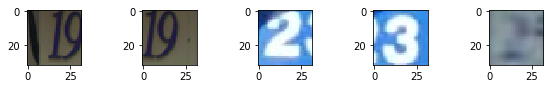

In [19]:
model_mlp, model_cnn = load_models(get_new_mlp_model(x_train), 'checkpoints_best_only/checkpoint', get_new_cnn_model(), 'checkpoints_best_only_cnn/checkpoint')
# randomly selecting 5 images and lables from test set.
rand_five_images_test = np.random.choice(x_test.shape[0], 5)

fig, ax = plt.subplots(1, 5, figsize=(10, 1))
# import pdb; pdb.set_trace()
for i, idx in enumerate(rand_five_images_test):
    ax[i].imshow(x_train[i])
plt.show()

(5, 32, 32, 3)
MLP predictions on 5 Random Test set images


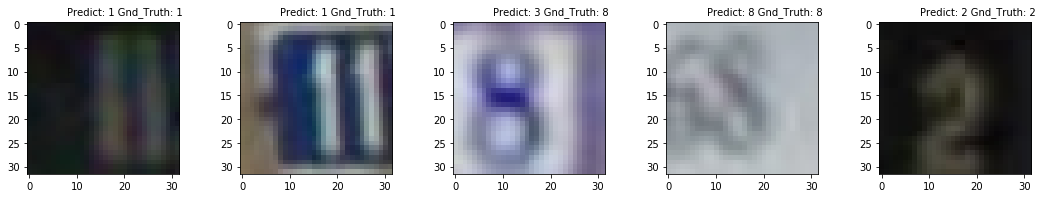

In [20]:
rand_test_imgs = x_test[rand_five_images_test, ...]
rand_test_targets = y_test[rand_five_images_test, ...]

mlp_pred = model_mlp.predict(rand_test_imgs)
print(rand_test_imgs.shape) # note, predict expects a 4th dim for batch size.

digit_map = {
    '0': 1,
    '1': 2,
    '2': 3,
    '3': 4,
    '4': 5,
    '5': 6,
    '6': 7,
    '7': 8,
    '8': 9,
    '9': 0
}
# np.argmax(rand_test_targets[0])
fig, axes = plt.subplots(1, 5, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
print(f'MLP predictions on 5 Random Test set images')
for i, (p, img, target) in enumerate(zip(mlp_pred, rand_test_imgs, rand_test_targets)):
    axes[i].imshow(img)
    axes[i].text(8, -2, f'Predict: {digit_map[str(np.argmax(p))]} Gnd_Truth: {digit_map[str(np.argmax(target))]}')

Distribution for MLP model


(array([5978., 4499., 2292., 2993., 2184., 2398., 1620., 1050., 1525.,
        1493.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

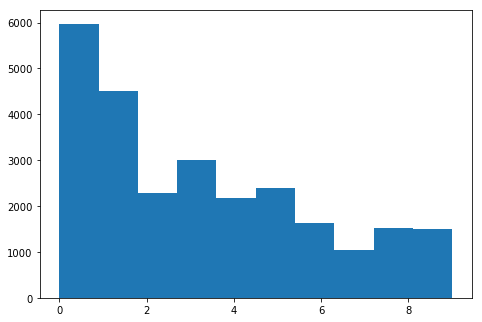

In [32]:
# all predictions made by model_mlp
preds = [np.argmax(p) for p in model_mlp.predict(x_test)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f'Distribution for MLP model')
ax.hist(preds) 

Predicted many 0s and 1s.

(5, 32, 32, 3)
CNN predictions on 5 Random Test set images


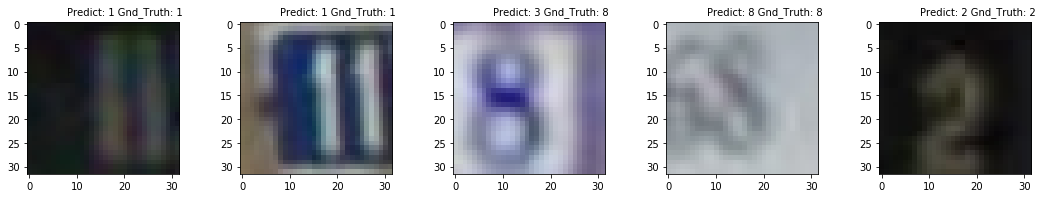

In [36]:
cnn_pred = model_cnn.predict(rand_test_imgs.astype('float32')) # would error out if did not cast to float32, originally uint8

print(rand_test_imgs.shape) # note, predict expects a 4th dim for batch size.

# np.argmax(rand_test_targets[0])
fig, axes = plt.subplots(1, 5, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
print(f'CNN predictions on 5 Random Test set images')
for i, (p, img, target) in enumerate(zip(mlp_pred, rand_test_imgs, rand_test_targets)):
    axes[i].imshow(img)
    axes[i].text(8, -2, f'Predict: {digit_map[str(np.argmax(p))]} Gnd_Truth: {digit_map[str(np.argmax(target))]}')

Distribution for CNN model


(array([5406., 4231., 2744., 2499., 2400., 2046., 1907., 1416., 1743.,
        1640.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

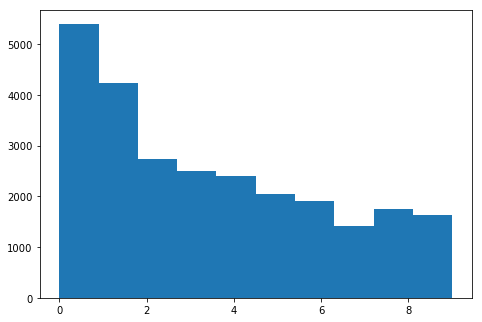

In [35]:
# all predictions made by model_mlp
preds_cnn = [np.argmax(p) for p in model_cnn.predict(x_test.astype('float32'))]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
print(f'Distribution for CNN model')
ax.hist(preds_cnn)

Predicted many 0s and 1s - similar to the MLP mdoel. Although, the 2 - 9 seem more smooth in distribtion compared to that of the mlp. Overall, right skewed.